# Lesson: Pandas ETL

## Introduction

[Pandas](https://pandas.pydata.org/docs/) is an easy to use data manipulation package. It primarily focuses on the transformation step, but it can extract and load as well.

Pandas is extremely popular for Python data engineering. There are many other Python data manipulation libraries (perhaps too many): [Polars](https://pola.rs/), [Dask](https://docs.dask.org/en/stable/), and [Apache Spark (PySpark)](https://spark.apache.org/docs/latest/api/python/getting_started/index.html). Pandas has been around for a while (17 years) and is trusty and reliable. Pandas has been criticized for memory inefficiencies.

### Learning Outcomes

When you've finished this lesson and its exercises, you should be able to:

- Use Pandas to extract.
- Use Pandas to transform: drop invalid rows, remove duplicates, change data types, filter records.
- Use Pandas to load.

## Set Up

We're using a movie review schema and a secondary data set from [movie_reviews.csv](movie_reviews.csv).

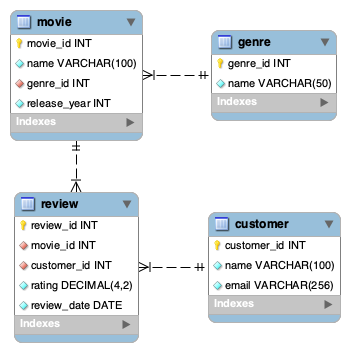

If you haven't already, use MySQL Workbench to open `week-04/lessons/pandas-etl/movie-reviews.sql` and execute the schema and data.

Set your [.env](.env) variables to your local database credentials.

## Extract

Pandas can extract from [many data sources](https://pandas.pydata.org/docs/user_guide/io.html):

- [read_csv](https://pandas.pydata.org/docs/user_guide/io.html#io-read-csv-table)
- [read_json](https://pandas.pydata.org/docs/user_guide/io.html#io-json-reader)
- [read_excel](https://pandas.pydata.org/docs/user_guide/io.html#io-excel-reader)
- [read_parquet](https://pandas.pydata.org/docs/user_guide/io.html#io-parquet)
- [read_sas](https://pandas.pydata.org/docs/user_guide/io.html#io-sas-reader)
- [read_sql](https://pandas.pydata.org/docs/user_guide/io.html#io-sql)
- ...

We'll start with our MySQL database and SQLAlchemy. Pandas doesn't support "raw" connections (`mysql.connector`), so we'll use SQLAlchemy.

<pre>

UserWarning: 
pandas only supports SQLAlchemy connectable (engine/connection) 
or database string URI 
or sqlite3 DBAPI2 connection. 
Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, self._cnx)
  
</pre>

In [42]:
from dynaconf import Dynaconf
from sqlalchemy import create_engine

def build_engine():
    settings = Dynaconf(envvar_prefix="DB", load_dotenv=True)
    return create_engine(settings.ENGINE_URL, echo=False)

engine = build_engine()

We extract from a SQL query to generate a `DataFrame`. Again, our schema is reliable. It's our single source of truth.

In [43]:
import pandas as pd

with engine.connect() as cnx, cnx.begin():
    sql = """
        SELECT
            c.customer_id,
            m.`name` movie_name,
            g.`name` genre,
            r.rating,
            r.review_date
        FROM review r
        INNER JOIN customer c ON r.customer_id = c.customer_id
        INNER JOIN movie m ON r.movie_id = m.movie_id
        INNER JOIN genre g ON m.genre_id = g.genre_id;
        """

    db_df = pd.read_sql(sql, cnx)

# shut down our engine
engine.dispose()

In [ ]:
db_df.head(7)

In [ ]:
db_df.info()

Then we'll use a CSV file to extract a `DataFrame`. This is third-party data and it's not as reliable.

In [46]:
csv_df = pd.read_csv("movie_reviews.csv")

In [ ]:
csv_df.head(7)

In [ ]:
csv_df.info()

## Transform

In our `db_df` and `csv_df` our column names don't match up. `db_df` uses `customer_id`. `csv_df` uses `anonymous_id`. So we'll rename `anonymous_id` to `customer_id` and then merge the `DataFrame`.

In [49]:
# rename csv_df.anonymous_id to csv_df.customer_id
csv_df.rename(columns={"anonymous_id": "customer_id"}, inplace=True)
# merge or join
df = pd.concat([db_df, csv_df])

In [ ]:
df.columns

In [ ]:
df.head(7)

In [ ]:
df.info()

In [ ]:
# drop na columns
print(f"original data: {len(df)}")
df = df.dropna(subset=["customer_id", "movie_name", "rating"])
print(f"remove invalid rows: {len(df)}")

Initially, our `db_df` had an integer `customer_id` and float `rating`. When we merge, our `customer_id` is a float (nullable) and our rating is an object.

In [ ]:
import re


def convert_percent_to_number(value):
    if isinstance(value, float):
        return value
    elif "%" in value:
        return float(value.replace("%", "")) / 10
    elif re.match(r"\d+.?\d*", value):
        return float(value)
    return 0.0


# the `dropna` method creates a slice, so we'll make an explicit copy.
# convert customer_id to int
# convert rating from string/percent to float
df = df.copy()
df["customer_id"] = df["customer_id"].astype(int)
df["rating"] = df["rating"].apply(convert_percent_to_number).astype(float)
df.info()

In [ ]:
# drop duplicate that match on customer_id, movie_name, and rating
df = df.drop_duplicates(subset=["customer_id", "movie_name", "rating"])
print(f"drop dupes: {len(df)}")

In [ ]:
# when we drop duplicate customer_id, movie_name, and rating,
# our customer_id and movie_name may be unique, but the rating differs.
# our condition is removing duplicate records and keeping none of them.
# `not` duplicate, keep none
df = df[~df.duplicated(subset=["customer_id", "movie_name"], keep=False)]
print(f"remove non-matched ratings: {len(df)}")

In [ ]:
# we filter rating values between 0 and 10
# (there are no records with rating less than 0 or greater than 10.)
condition = (df["rating"] >= 0.0) & (df["rating"] <= 10.0)
df = df[condition]
print(f"filter rating: {len(df)}")

## Load

Our `DataFrame` has a method, `to_csv`, that allows us to write a CSV.

In [58]:
df.to_csv("load.csv", index=False)

### Efficient Code

When we remove our comments and don't print `df.info()`, `df.head()` repeatedly, our total lines of code are 75. We get a lot done with a few lines of ETL. (We could always make it _more_ efficient.)

Our Pandas code probably shouldn't be unstructured. We should include classes, and those classes should be testable.

Find our [etl.py](etl.py) module. Our classes look fairly similar but we don't require a repository or writer. We have a `Transformer` class which uses Pandas and an `ETLProcessor` class which also uses Pandas. 

```py
import logging
import re

import pandas as pd

logger = logging.getLogger(__name__)


def convert_percent_to_number(value):
    if isinstance(value, float):
        return value
    elif "%" in value:
        return float(value.replace("%", "")) / 10
    elif re.match(r"\d+.?\d*", value):
        return float(value)
    return 0.0


class Transformer:
    def transform(self, df):
        logger.info(f"original: {len(df)}")

        df = df.dropna(subset=["customer_id", "movie_name", "rating"])
        logger.info(f"drop na: {len(df)}")

        df = df.copy()
        df["customer_id"] = df["customer_id"].astype(int)
        df["rating"] = df["rating"].apply(convert_percent_to_number).astype(float)
        logger.info(f"convert: {len(df)}")

        df = df.drop_duplicates(subset=["customer_id", "movie_name", "rating"])
        logger.info(f"drop dupes: {len(df)}")

        df = df[~df.duplicated(subset=["customer_id", "movie_name"], keep=False)]
        logger.info(f"remove non-matched ratings: {len(df)}")

        condition = (df["rating"] >= 0.0) & (df["rating"] <= 10.0)
        df = df[condition]
        logger.info(f"filter 0 <= rating >= 10: {len(df)}")

        return df


class ETLProcessor:
    def __init__(
        self,
        cnx,
        csv_path,
        load_path,
        transformer: Transformer,
    ):
        self._cnx = cnx
        self._csv_path = csv_path
        self._load_path = load_path
        self._transformer = transformer

    def extract_sql(self):
        sql = """
            SELECT
                c.customer_id,
                m.`name` movie_name,
                g.`name` genre,
                r.rating,
                r.review_date
            FROM review r
            INNER JOIN customer c ON r.customer_id = c.customer_id
            INNER JOIN movie m ON r.movie_id = m.movie_id
            INNER JOIN genre g ON m.genre_id = g.genre_id;
            """

        return pd.read_sql(sql, self._cnx)

    def extract_csv(self):
        return pd.read_csv(self._csv_path)

    def extract(self):
        df = self.extract_sql()

        csv_df = self.extract_csv()
        csv_df.rename(columns={"anonymous_id": "customer_id"}, inplace=True)

        return pd.concat([df, csv_df])

    def load(self, df):
        df.to_csv(self._load_path, index=False)

    def process(self):
        df = self.extract()
        df = self._transformer.transform(df)
        self.load(df)

```

We can choose to separate concerns with extraction classes and loader classes, though it might make it _more_ confusing.

Find our [main.py](main.py) module. Our `ETLProcessor` accepts a SQLAlchemy connection, a third-party CSV path, a CSV load path, and a `Transformer`. It gets a lot done with little code.

```py
import logging
import os

from dynaconf import Dynaconf
from etl import ETLProcessor, Transformer
from sqlalchemy import create_engine


def run():
    logging.basicConfig(level=logging.NOTSET)

    movie_review_path = os.path.join(os.path.dirname(__file__), "movie_reviews.csv")
    load_path = os.path.join(os.path.dirname(__file__), "load.csv")

    def build_engine():
        settings = Dynaconf(envvar_prefix="DB", load_dotenv=True)
        return create_engine(settings.ENGINE_URL, echo=False)

    engine = build_engine()

    transformer = Transformer()

    with engine.connect() as cnx, cnx.begin():
        processor = ETLProcessor(
            cnx,
            movie_review_path,
            load_path,
            transformer,
        )
        processor.process()

    engine.dispose()


if __name__ == "__main__":
    run()

```